In [2]:
import numpy as np
import matplotlib.pyplot as plt

#%matplotlib inline
#plt.style.use('ggplot')
#%precision 4
np.set_printoptions(precision=4, suppress=True)

#make the axes white
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
        "axes.titlecolor":"w"}
plt.rcParams.update(params)

#how to compress lists with masks

from itertools import compress
list1=[1,2,3]
mask=[True,False,True]
print([i for i in compress(list1, mask)])

[1, 3]


## Interpolation: 

`scipy.interpolate` is useful for fitting a function from experimental data and thus evaluating points where no measure exists. The module is based on the FITPACK Fortran subroutines.

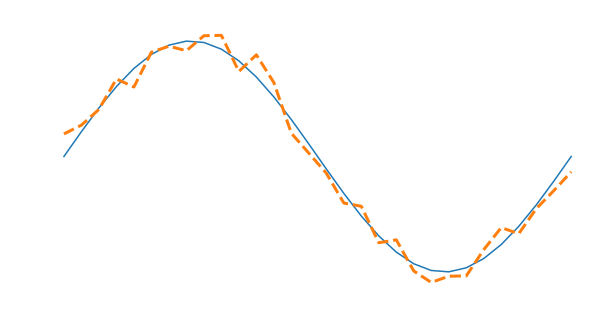

In [88]:
# the actual measurements
measured_time = np.linspace(0, 1, 30)
noise = (np.random.random(len(measured_time))*2 -1) * .2
measures = np.sin(2 * np.pi * measured_time) + noise #here's the sinus of an array
plt.figure(figsize=(10,5))
plt.title("Sin(x)+Noise")
plt.plot(measured_time,np.sin(2 * np.pi * measured_time))
plt.plot(measured_time,measures, "--",lw=3);

In [89]:
from scipy.interpolate import interp1d


The kind of interpolation can be specified: linear is the default;  *zero*, *slinear*, *quadratic* and *cubic* refer to a [spline](https://en.wikipedia.org/wiki/Spline) interpolation of zeroth, first, second or third order; *previous* and *next* simply return the previous or next value of the point.

In [90]:
#  fit with the meas_time...

# linear interpolation
linear_interp = interp1d(measured_time, measures)
# cubic interpolation
cubic_interp = interp1d(measured_time, measures, kind='cubic')

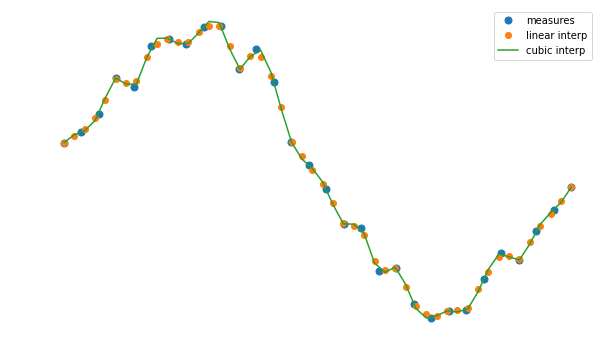

In [107]:
#..plot with denser interval

interpolation_time = np.linspace(0, 1, 50)

plt.figure(figsize=(10, 6))
plt.plot(measured_time, measures, 'o', ms=7, label='measures')

linear_results = linear_interp(interpolation_time)
plt.plot(interpolation_time, linear_results, "o", label='linear interp')

cubic_results = cubic_interp(interpolation_time)
plt.plot(interpolation_time, cubic_results, label='cubic interp')
plt.legend();
#plt.show()

In [140]:
# checking the punctual results
import scipy.spatial.distance as dist
x=1/4.
print ("sin(x):",np.sin(2 * np.pi * x), 
       "linear prediction:",linear_interp(x),
       "cubic prediction:", cubic_interp(x))

t=linear_interp(measured_time)
u=cubic_interp(measured_time)
v=measures
linear_error= dist.euclidean(t,v)
l_err=np.linalg.norm(t-v)
cubic_error= dist.euclidean(u,v)
c_err=np.linalg.norm(u-v)

print("%.2e"%linear_error, "%.2e"%cubic_error, l_err, c_err)

sin(x): 1.0 linear prediction: 0.9477035379852761 cubic prediction: 0.9350344799481913
0.00e+00 4.65e-16 0.0 4.652682298944613e-16


# Optimization and fit: `scipy.optimize`

Optimization is the problem of finding a numerical solution to a minimization or equality.

The `scipy.optimize` module provides algorithms for function minimization (scalar or multi-dimensional), curve fitting and root finding.

In [5]:
from scipy import optimize

## Curve Fitting

Fitting is the core business of data analysis or in general data science. If you *know* the underlying model, then the overall problem is simple. If you don't, then it is a very delicate issue.

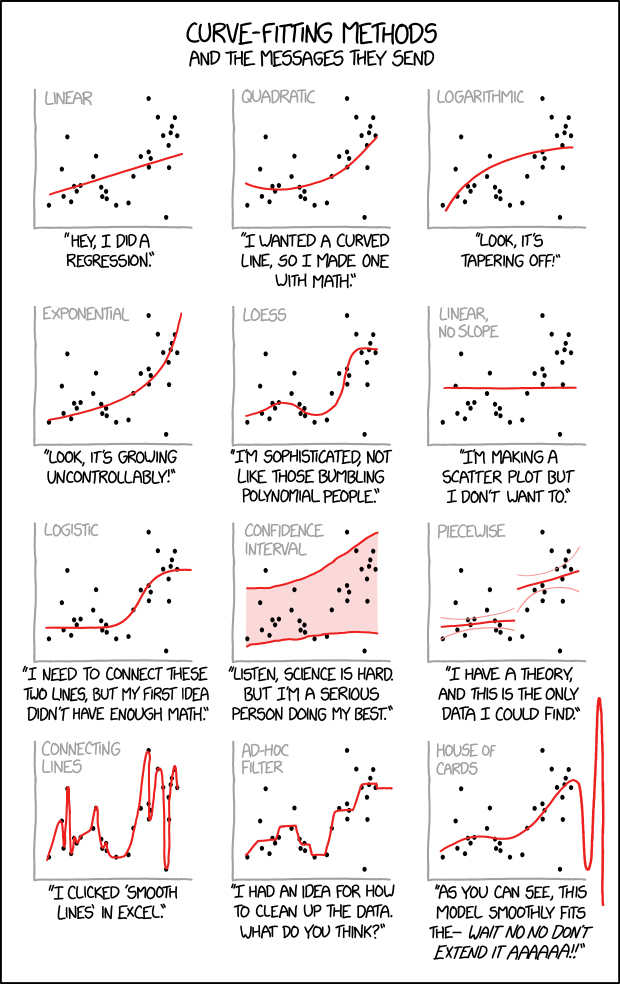

In [8]:
from IPython.display import Image
Image("xkcd_curve_fitting.png")

Let's take some data, sampled from a sine distribution and affected by random noise

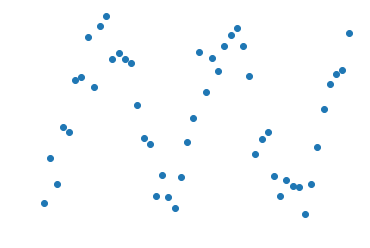

In [7]:
x_data = np.linspace(-5, 5, num=50)
y_data = 2.9 * np.sin(1.5 * x_data) + np.random.normal(size=50) #knowing the prior is easy, mate!

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.scatter(x_data, y_data);

If we *known* that the data is sampled from a sine function and we just need to find its parameters, in this case amplitude and frequency, we can do that by least squares curve fitting. 

In [8]:
def f(x, A, nu):
    return A * np.sin(nu * x) #same data-generating function

In [13]:
# fit by means of curve_fit
# p0 are the guessed values for the parameters
params, params_covariance = optimize.curve_fit(f, x_data, y_data, p0=[2, 2], full_output=False) # to =True get the full output
print(params)
print (params_covariance)

[3.1042 1.5193]
[[ 0.0278 -0.0003]
 [-0.0003  0.0003]]


As every fitting problem, this transaltes into a minimization problem: the function `f(x_data; params)-y_data` is minimized

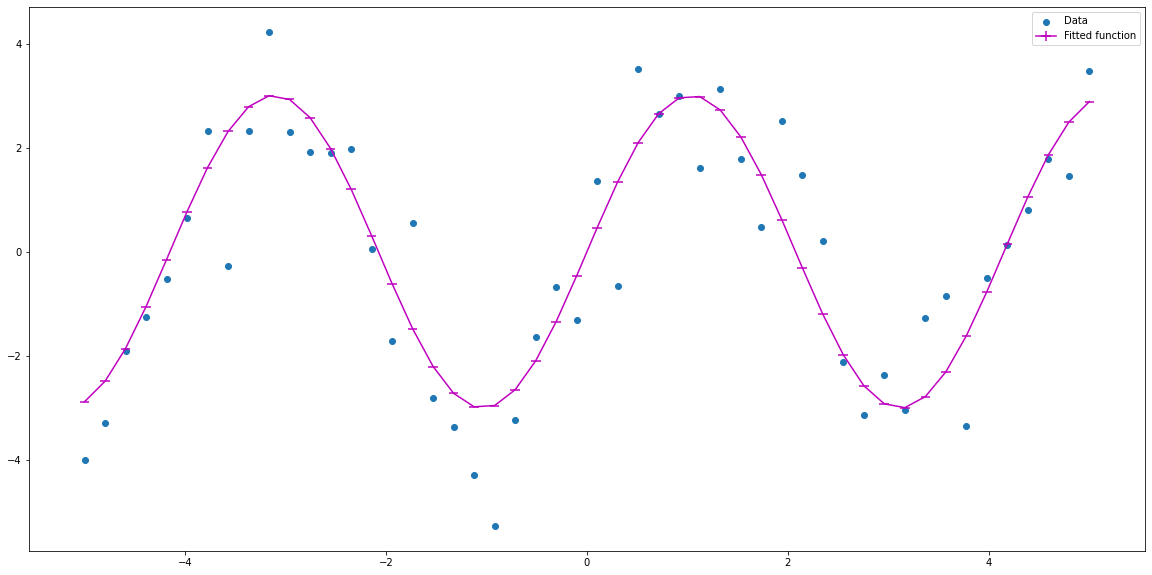

In [32]:
plt.figure(figsize=(20,10))
plt.scatter(x_data, y_data, label='Data')
plt.errorbar(x_data, f(x_data, params[0], params[1]), xerr = params_covariance[0,0], yerr=params_covariance[1,1], color="m",
         label='Fitted function')

plt.legend(loc='best')

plt.show()

##  Roots of scalar and functions

Several methods are there for $f(x): {\rm I\!R} \to {\rm I\!R}$, e.g. [Newton-Raphson](https://en.wikipedia.org/wiki/Newton%27s_method) or Brent (a safer version of the secant method, which combines a bracketing strategy with a parabolic approximation)

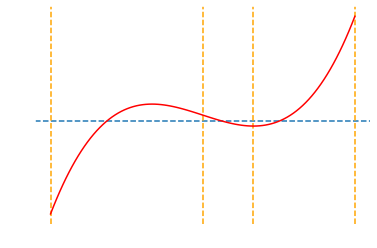

In [73]:
def f(x):
    return x**3-3*x+1

x = np.linspace(-3,3,100)
plt.axhline(0, linestyle="--"); 
vlines=[-3,0,1,3]
for i in vlines: plt.axvline(i, linestyle="--", color="orange")
plt.plot(x, f(x),'r-');

In [14]:
from scipy.optimize import brentq
brentq(f, -3, 0), brentq(f, 0, 1), brentq(f, 1,3) #f, min, max

(-1.8794, 0.3473, 1.5321)

In [15]:
from scipy.optimize import newton
newton(f, -3), newton(f, 0), newton(f, 3)

(-1.8794, 0.3473, 1.5321)

### Warning 
Safer algorithms are brentq, brenth, ridder, and bisect, but they all require that the root first be bracketed in an interval where the function changes sign. [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton.html)

In case of $f(x): {\rm I\!R}^2 \to {\rm I\!R}$, the `optimize.root` is available, also implementing several methods (MINPACK's hybrd being the default)

In [83]:
from scipy.optimize import root, fsolve

def f(x):
    return [x[1] - 3*x[0]*(x[0]+1)*(x[0]-1),
            .25*x[0]**2 + x[1]**2 - 1]

solutions = root(f, (0.5, 0.5))
print (solutions.x)
print (np.all(f(solutions.x)==(0,0)), "means the sols aren't = but close",np.allclose(f(solutions.x),0))

[1.1169 0.8295]
False meaning the sols aren't = but close True


## Minimization of a function

The `minimize_scalar` function will find the minimum, and can also be told to search within given bounds. By default, it uses the Brent algorithm.

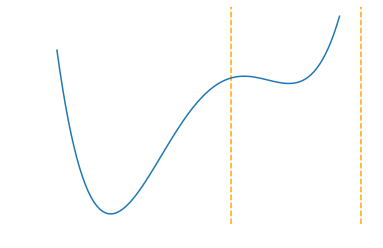

In [3]:
def f(x):
    return x**4 + 3*(x-2)**3 - 15*(x)**2 + 1

x = np.linspace(-8, 5, 100)
vlines=[0,6]
for i in vlines: plt.axvline(i, linestyle="--", color="orange")
plt.plot(x, f(x));

#keras , py-torch has important functions to minimize other func :-)

In [6]:
#not equivalent
res1 = optimize.minimize_scalar(f)
res2 = optimize.minimize_scalar(f, method='Brent',  bracket=[2,6]) #bounds=[4,6] doesn't affect the result
print(res1, "\n", res2)

     fun: -803.3955308825884
    nfev: 17
     nit: 11
 success: True
       x: -5.528801125219663 
      fun: -803.3955308825886
    nfev: 15
     nit: 8
 success: True
       x: -5.528801096956229


In [7]:
optimize.minimize_scalar(f, method="golden", bounds=[2,6])

     fun: -803.3955308825886
    nfev: 44
     nit: 37
 success: True
       x: -5.5288011239904655

In [8]:
optimize.minimize_scalar(f, method='bounded', bounds=[0, 6]) #usefull for LOCAL minima

     fun: -54.21003937712762
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 2.668865104039653

### Local and global minima

$sinc(x)=\sin(\pi x)/(\pi x).$

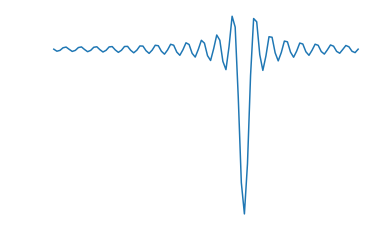

In [139]:
def f(x, offset):
    return -np.sinc(x-offset)

x = np.linspace(-20, 20, 100)
plt.plot(x, f(x, 5));

In [145]:
# note how additional function arguments are passed in
solution = optimize.minimize_scalar(f, args=5)
solution

     fun: -0.049029624014074166
    nfev: 15
     nit: 10
 success: True
       x: -1.4843871263953001

Optimization results are packed accordingly to  this [format](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult)

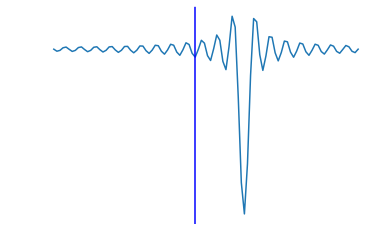

In [146]:
plt.plot(x, f(x, 5))
plt.axvline(solution.x,color='b')

When the function oscillates a lot, often the global minimum is not found (it works with the offset of 2). To cope with that, several ranges needs to be explored. The way out is to figure out the minimum sampling different intervals.

In [23]:
lower = np.random.uniform(-20, 20, 100)
upper = lower + 1
solutions = [optimize.minimize_scalar(f, args=(5,), bracket=(l, u)) for (l, u) in zip(lower, upper)]

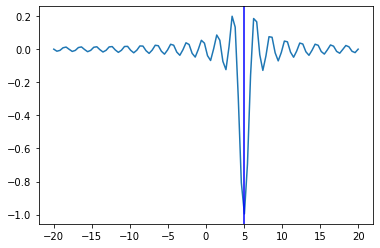

In [24]:
idx = np.argmin([solution.fun for solution in solutions])
solution = solutions[idx]

plt.plot(x, f(x, 5))
plt.axvline(solution.x, color='b');

In [190]:
#how to compress lists with masks

from itertools import compress
list1=[1,2,3]
mask=[True,False,True]
print([i for i in compress(list1, mask)])

[1, 3]


# !!!Alternatively a dedicated method is available!!!

In [242]:
from scipy.optimize import basinhopping

x0 = 0; offset=-5 #jump to -5 to 12 easily but with 1000 iteration may be demanging...
solution = basinhopping(f, x0, stepsize=1, niter=1000, minimizer_kwargs={'args': (offset,)})
solution.x

array([-5.])

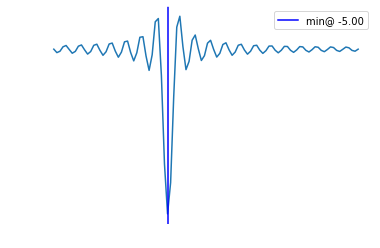

In [243]:
plt.plot(x, f(x, offset))
plt.axvline(solution.x, color='b', label=("min@ %.2f"%offset))
plt.legend();

Minimization of f(x): ${\rm I\!R}^n \to {\rm I\!R}$ is a whole field of study per se. You should have seen it treated in details in other courses.

# Statistics and random numbers: `scipy.stats`

The module scipy.stats contains statistical tools and probabilistic descriptions of random processes. Random number generators for various random process can be found in numpy.random.

Given observations of a random process, their histogram is an estimator of the random processâ€™s PDF (probability density function):

The area under the hist: 1.0


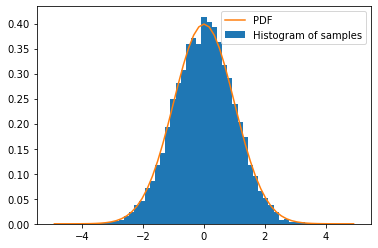

In [11]:
# Sample from a normal distribution using numpy's random number generator
samples = np.random.normal(size=10000)

# Compute a histogram of the sample
bins = np.linspace(-5, 5, 60)

# Compute the PDF on the bin centers from scipy distribution object
from scipy import stats
bin_centers = 0.5*(bins[1:] + bins[:-1])
pdf = stats.norm.pdf(bin_centers) #not fitting the hist

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 4))
n,binss,patches = plt.hist(samples, bins, label="Histogram of samples", density=True) 
plt.plot(bin_centers, pdf, label="PDF")
plt.legend();

print("The area under the hist:", np.sum(np.diff(binss)*n)) #density=Flase --> pdf can't be seen

If we know that the random process belongs to a given family of random processes, such as normal processes, we can do a maximum-likelihood fit of the observations to estimate the parameters of the underlying distribution. Here we fit a normal process to the observed data:


In [16]:
mean, std = stats.norm.fit(samples)
print (mean, std)
#we could have introd a phase but the fit is not under our control
#using the built-in function of scipy.stats

0.010752097595585965 0.9866679561653714


## Statistical tests
#### Compatibility of 2 synthetic data

*A statistical test is a decision indicator. For instance, if we have two sets of observations, that we assume are generated from Gaussian processes, we can use a [T_Stud-test](https://en.wikipedia.org/wiki/Student%27s_t-test) to decide whether the means of two sets of observations are significantly different:
<br> *Use the Chi-square to understand the which of the red func above best describe data but it's meaningfull only if we have at least 2 options!

Integr of hist1 is 1.0 while for the 2nd is: 1.0


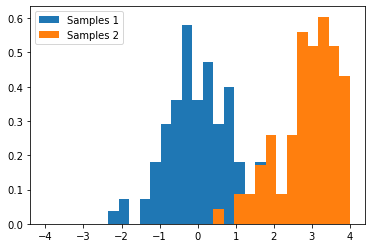

In [30]:
# Generates 2 sets of observations
np.random.seed(1)
samples1 = np.random.normal(0, size=100)
samples2 = np.random.normal(3, size=100)

# Compute a histogram of the sample
bins = np.linspace(-4, 4, 30)
histogram1, bins1 = np.histogram(samples1, bins=bins, density=True)
histogram2, bins2 = np.histogram(samples2, bins=bins, density=True)

print("Integr of hist1 is", np.sum(np.diff(bins1)*histogram1), "while for the 2nd is:", np.sum(np.diff(bins2)*histogram2))

plt.figure(figsize=(6, 4))
plt.hist(samples1, bins=bins, density=True, label="Samples 1")
plt.hist(samples2, bins=bins, density=True, label="Samples 2")
plt.legend(loc='best')
plt.show()

In [31]:
stats.ttest_ind(samples1, samples2)

Ttest_indResult(statistic=-23.936827910311237, pvalue=2.343211219767105e-60)

Usually with a pvalue of $0.13 (>0.1>0.05)$ the null-hypothesis (=avg) is accepted, i.e. the 2 distr have similar mean (as we can see above).
using t-test variance are equal. If not, use equal_var=False and Welch's test is performed: [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)

In [29]:
# most of the test statistics are available 
stats.chisquare(samples1,samples2)

Power_divergenceResult(statistic=-2650.2825023014834, pvalue=1.0)

## Numerical integration: `scipy.integrate`

### Function integrals

The most generic integration routine is `scipy.integrate.quad()`, which integrate from a to b (possibly infinite interval) using a technique from the Fortran library QUADPACK.

 Let's compute $\int_0^{\pi/2} \sin{\theta}d\theta$:


In [34]:
from scipy.integrate import quad, quadrature
res, err = quad(np.sin, 0, np.pi/2)

# An alternative is the gaussian quadrature
res1, err1 = quadrature(np.sin, 0, np.pi/2)

print (res, err, res1, err1)
print (np.allclose(res, 1))   # res is the result, is should be close to 1
print (np.allclose(err, 1 - res))  # err is an estimate of the err

0.9999999999999999 1.1102230246251564e-14 0.9999999999999535 3.961175831790342e-11
True
True


`scipy.integrate.nquad()` generalize to multiple integration variables

In [46]:
from scipy.integrate import nquad
func = lambda x0,x1,x2,x3 : x0**2 + x1*x2 - x3**3 + np.sin(x0) + (
                                1 if (x0-.2*x3-.5-.25*x1>0) else 0)
points = [[lambda x1,x2,x3 : 0.2*x3 + 0.5 + 0.25*x1], [], [], []]
def opts0(*args, **kwargs):
    return {'points':[0.2*args[2] + 0.5 + 0.25*args[0]]} 

result, abserr, out = nquad(func, [[0,1], [-1,1], [.13,.8], [-.15,1]], opts=[opts0,{},{},{}], full_output=True)

print (result, abserr)
print (out)

1.5267454070738635 2.943736000140233e-14
{'neval': 388962}


### Integrating differential equations

`scipy.integrate` also features routines for integrating Ordinary Differential Equations (ODE). In particular, `scipy.integrate.odeint()` solves ODE of the form:

```python
dy/dt = rhs(y1, y2, .., t0,...)
```

As an introduction, let us solve the ODE $\frac{dy}{dt} = -2 y$ between $t = 0 \dots 4$, with the initial condition $y(t=0) = 1$. <br>First the function computing the derivative of the position needs to be defined:


In [47]:
def calc_derivative(ypos, time):
    return -2 * ypos

Then, to compute y as a function of time:

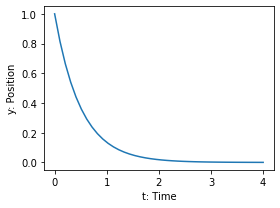

In [48]:
from scipy.integrate import odeint
time_vec = np.linspace(0, 4, 40)
y = odeint(calc_derivative, y0=1, t=time_vec)


plt.figure(figsize=(4, 3))
plt.plot(time_vec, y)
plt.xlabel('t: Time')
plt.ylabel('y: Position')
plt.tight_layout()

Let us integrate a more complex ODE: a damped spring-mass oscillator. The position of a mass attached to a spring obeys the 2nd order ODE $y'' + 2 \varepsilon \omega_0  y' + \omega_0^2 y = 0$ with $\omega_0^2 = k/m$ with $k$ the spring constant, $m$ the mass and $\varepsilon = c/(2 m \omega_0)$ with $c$ the damping coefficient. We set:

In [49]:
mass = 0.5  # kg
kspring = 4  # N/m
cviscous = 0.4  # N s/m

# and thus
eps = cviscous / (2 * mass * np.sqrt(kspring/mass))
omega = np.sqrt(kspring / mass)

For `odeint()`, the 2nd order equation needs to be transformed in a system of two first-order equations for the vector $Y = (y, y')$: the function computes the velocity and acceleration:

In [57]:
def calc_derivative(yvec, time, eps, omega): #y', y''
    return (yvec[1], -2 * eps * omega * yvec[1] - omega **2 * yvec[0])

In [51]:
time_vec = np.linspace(0, 10, 100)
yinit = (1, 0)
yarr = odeint(calc_derivative, yinit, time_vec, args=(eps, omega))

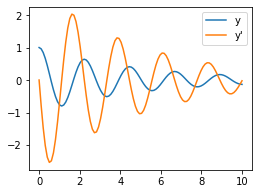

In [52]:
plt.figure(figsize=(4, 3))
plt.plot(time_vec, yarr[:, 0], label='y')
plt.plot(time_vec, yarr[:, 1], label="y'")
plt.legend(loc='best');

## Fast Fourier Trasform

Used a lot for phenomena that are characterized by frequency (periodic) spectrum is perculiar and gives insight on the true model.
The `scipy.fftpack` module computes fast Fourier transforms (FFTs) and offers utilities to handle them. The main functions are:

* `scipy.fftpack.fft()` to compute the FFT
* `scipy.fftpack.fftfreq()` to generate the sampling frequencies
* `scipy.fftpack.ifft()` computes the inverse FFT, from frequency space to signal space

Let's generate a (syntetic) noisy signal:

The sin has 0.25 frequency


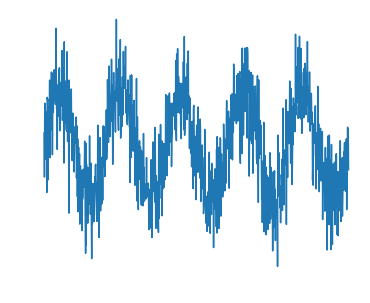

In [11]:
import numpy as np
from scipy import fftpack
from matplotlib import pyplot as plt

# Seed the random number generator
np.random.seed(1234)

time_step = 0.02
period = 4.
print("The sin has %.4s frequency"% (1/period))

time_vec = np.arange(0, 20, time_step)
sig = (np.sin(2 * np.pi / period * time_vec)
       + 0.5 * np.random.randn(time_vec.size))



plt.figure(figsize=(6, 5))
plt.plot(time_vec, sig, label='Original signal')
plt.show()

Let's compute and plot the power spectrum

0.25 0.25 True


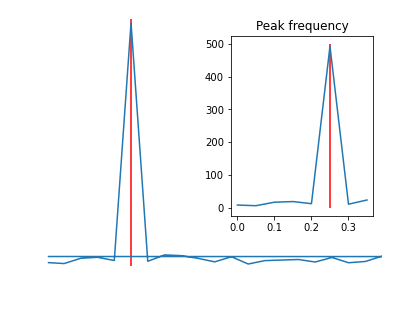

In [22]:
# The FFT of the signal
sig_fft = fftpack.fft(sig)

# And the power (sig_fft is of complex dtype) spectrum, 
#i.e. weights (dep  the relevance of a given component) of the Fourier comp
power = np.abs(sig_fft)

# The corresponding frequencies
sample_freq = fftpack.fftfreq(sig.size, d=time_step)

# Find the peak frequency: we can focus on only the positive frequencies
pos_mask = np.where(sample_freq >= 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]
#print(power[pos_mask][:5].argmax(), freqs[:5])

# Plot the FFT power
fig=plt.figure(figsize=(6, 5))
plt.plot(sample_freq, power)
plt.xlim(0,1)
plt.xlabel('Frequency [Hz]')
plt.ylabel('power')
plt.vlines(x=peak_freq,ymin=0,ymax=500, color="r")

# Check that it does indeed correspond to the frequency that we generate
# the signal with
print (peak_freq, 1./period, np.allclose(peak_freq, 1./period))

# An inner plot to show the peak frequency
#make the axes white
params = {"ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k",
        "axes.titlecolor":"k"}
plt.rcParams.update(params)


axes = plt.axes([0.55, 0.3, 0.33, 0.5])
plt.title('Peak frequency')
plt.plot(freqs[:8], power[:8])
#plt.setp(axes)
plt.vlines(x=peak_freq,ymin=0,ymax=500, color="r");


# scipy.signal.find_peaks_cwt can also be used for more advanced
# peak detection  

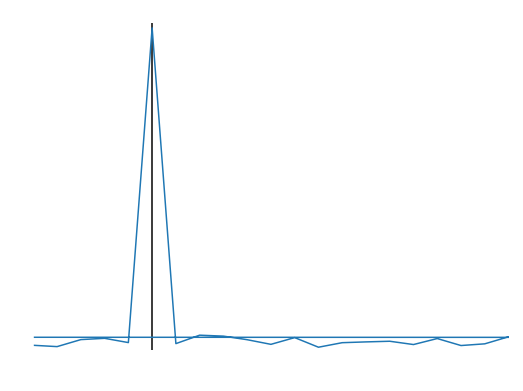

In [14]:
sig_fft=fftpack.fft(sig)
freqs=fftpack.fftfreq(sig.size, d=time_step)
power=np.abs(sig_fft)

pos_freq=freqs[freqs>=0]
idx=np.argmax(power[pos_mask])
pow_max=power[idx]
freq_max=freqs[idx]

fig=plt.figure(figsize=(20,10))
axes = fig.add_axes([0.55, 0.3, 0.33, 0.5])

plt.plot(freqs, power)
plt.vlines(freq_max, 0,500)
plt.xlim(0,1);

/home/hal20/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


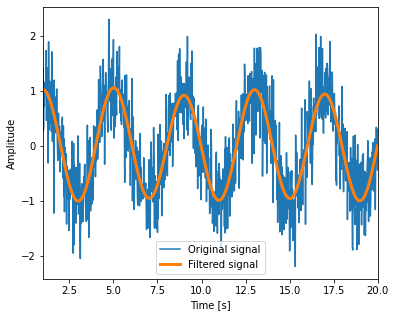

In [9]:
high_freq_fft = sig_fft.copy()
high_freq_fft[np.abs(sample_freq) > peak_freq] = 0
filtered_sig = fftpack.ifft(high_freq_fft)

plt.figure(figsize=(6, 5))
plt.plot(time_vec, sig, label='Original signal')
plt.plot(time_vec, filtered_sig, linewidth=3, label='Filtered signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim(1,20)
plt.legend(loc='best')

Exists many other libraries that performs different tasks (ex., for minimisation use Py-Torch and the last project)